<b>Predict rainfall in Singapore</b>

This is my first personal machine learning project. As usual, I am always open to feedback and comments 😄

# Fetch data from csv files

In [89]:
import os 
import glob
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingRegressor
from scipy.stats import randint
from scipy.stats import uniform
from mlxtend.feature_selection import SequentialFeatureSelector
from pandas.plotting import scatter_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDERS = os.listdir("datasets")
attribs = ["month"] + DATA_FOLDERS

def fetch_weather_data():
    """Load the weather dataset from CSV files.
    
    Parameters
    ----------
    None
    
    Return
    ----------
    A DataFrame object with the complete dataset 
    
    """
    
    drop_month = False
    
    # An empty array for storage
    all_data = np.array([])
    
    for folder in DATA_FOLDERS:
        # Find the csv files in each folder
        csv_file = glob.glob(os.path.join("datasets", folder, "*.csv"))[0]
        df = pd.read_csv(csv_file)
        
        if drop_month:
            df.drop("month", axis=1, inplace=True)
            
        drop_month = True
        
        data = df.values
    
        # if all_data.size is 0, return data
        # if all_data.size is not 0, concatenate the arrays
        all_data = np.hstack([all_data, data]) if all_data.size else data
    
    return pd.DataFrame(all_data, columns=attribs)

# Ignore useless warnings
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Explore data

In [90]:
data = fetch_weather_data()
data.head()

,month,maximum_rainfall_in_a_day,max_temperature,mean_rh,mean_sunshine_hrs,mean_temp,monthly_total_rainfall,no_of_rainy_days,rh_extremes_minimum,temp_extremes_min,temp_mean_daily_max,temp_mean_daily_min
0,1982-01,36.5,31.9,81.2,5.6,25.9,107.1,10,49,21.9,29.8,23.3
1,1982-02,9.4,34.3,79.5,7.6,27.1,27.8,5,49,22.6,32.3,23.9
2,1982-03,61.7,34.3,82.3,5.1,27.2,160.8,11,51,22.3,31.7,24.3
3,1982-04,45.1,33.2,85.9,4.7,27,157,14,54,22.2,31.4,24.3
4,1982-05,33,32.9,83.2,5.8,28,102.2,10,57,23.7,31.7,25.2


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 12 columns):
month                        450 non-null object
maximum_rainfall_in_a_day    450 non-null object
max_temperature              450 non-null object
mean_rh                      450 non-null object
mean_sunshine_hrs            450 non-null object
mean_temp                    450 non-null object
monthly_total_rainfall       450 non-null object
no_of_rainy_days             450 non-null object
rh_extremes_minimum          450 non-null object
temp_extremes_min            450 non-null object
temp_mean_daily_max          450 non-null object
temp_mean_daily_min          450 non-null object
dtypes: object(12)
memory usage: 42.3+ KB


In [92]:
# Check for null values

data.isnull().sum()

month                        0
maximum_rainfall_in_a_day    0
max_temperature              0
mean_rh                      0
mean_sunshine_hrs            0
mean_temp                    0
monthly_total_rainfall       0
no_of_rainy_days             0
rh_extremes_minimum          0
temp_extremes_min            0
temp_mean_daily_max          0
temp_mean_daily_min          0
dtype: int64

- There are 450 data instance without any null values.
- Note that the numerical attributes are type object. Let's cast it to type float.

In [93]:
num_data = data[DATA_FOLDERS].astype('float64')
cat_data = data['month']


data = pd.concat([cat_data, num_data], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 12 columns):
month                        450 non-null object
maximum_rainfall_in_a_day    450 non-null float64
max_temperature              450 non-null float64
mean_rh                      450 non-null float64
mean_sunshine_hrs            450 non-null float64
mean_temp                    450 non-null float64
monthly_total_rainfall       450 non-null float64
no_of_rainy_days             450 non-null float64
rh_extremes_minimum          450 non-null float64
temp_extremes_min            450 non-null float64
temp_mean_daily_max          450 non-null float64
temp_mean_daily_min          450 non-null float64
dtypes: float64(11), object(1)
memory usage: 42.3+ KB


In [94]:
data.describe()

,maximum_rainfall_in_a_day,max_temperature,mean_rh,mean_sunshine_hrs,mean_temp,monthly_total_rainfall,no_of_rainy_days,rh_extremes_minimum,temp_extremes_min,temp_mean_daily_max,temp_mean_daily_min
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,52.593556,33.372667,82.600444,5.654222,27.647333,177.109333,14.035556,50.880000,22.614000,31.508222,24.874000
std,35.866485,0.819003,3.240597,1.202056,0.803586,113.101533,4.924696,5.448998,0.742268,0.869528,0.722754
min,0.200000,31.300000,72.000000,2.700000,25.400000,0.200000,1.000000,33.000000,20.200000,28.800000,22.900000
25%,30.750000,32.800000,80.800000,4.800000,27.100000,90.450000,11.000000,48.000000,22.100000,31.000000,24.300000
50%,43.450000,33.300000,82.900000,5.600000,27.700000,158.950000,14.000000,51.000000,22.600000,31.500000,24.800000
75%,63.150000,33.900000,84.900000,6.400000,28.275000,238.225000,18.000000,55.000000,23.075000,32.000000,25.375000
max,216.200000,36.000000,90.700000,9.300000,29.500000,765.900000,27.000000,61.000000,25.400000,34.400000,26.700000


In [95]:
data.head()

,month,maximum_rainfall_in_a_day,max_temperature,mean_rh,mean_sunshine_hrs,mean_temp,monthly_total_rainfall,no_of_rainy_days,rh_extremes_minimum,temp_extremes_min,temp_mean_daily_max,temp_mean_daily_min
0,1982-01,36.5,31.9,81.2,5.6,25.9,107.1,10.0,49.0,21.9,29.8,23.3
1,1982-02,9.4,34.3,79.5,7.6,27.1,27.8,5.0,49.0,22.6,32.3,23.9
2,1982-03,61.7,34.3,82.3,5.1,27.2,160.8,11.0,51.0,22.3,31.7,24.3
3,1982-04,45.1,33.2,85.9,4.7,27.0,157.0,14.0,54.0,22.2,31.4,24.3
4,1982-05,33.0,32.9,83.2,5.8,28.0,102.2,10.0,57.0,23.7,31.7,25.2


## Check and remove outliers

In [96]:
from collections import Counter

def detect_outliers(df, features, n=2):
    '''Find the instances with more than n outliers
    
    Parameters
    ----------
    df: DataFrame object
        The complete dataset
    n: int
        Max number of outliers allowed for each instance
    features: list 
        Numerical features to check for outliers
    
    Return
    ----------
    Indices of instances with more than n outliers
    '''
    
    outliers_indices = []
    
    for feature in features:
        # First quartile
        Q1 = df[feature].quantile(0.25)
        # Second quartile
        Q3 = df[feature].quantile(0.75)
        # Interquartile range
        IQR = Q3 - Q1
        # The indices of instance with outliers at feature column
        outliers_idx = df[(df[feature] <= Q1- (IQR * 1.5)) | (df[feature] >= Q3 + (IQR * 1.5))].index
        outliers_indices.extend(outliers_idx) 
        
    count_outliers = Counter(outliers_indices)
    instance_with_multiple_outliers = [item for item, count in count_outliers.items() if count>n]

    return instance_with_multiple_outliers

In [97]:
instance_with_multiple_outliers = detect_outliers(data, DATA_FOLDERS)
instance_with_multiple_outliers.sort()

data.iloc[instance_with_multiple_outliers]

,month,maximum_rainfall_in_a_day,max_temperature,mean_rh,mean_sunshine_hrs,mean_temp,monthly_total_rainfall,no_of_rainy_days,rh_extremes_minimum,temp_extremes_min,temp_mean_daily_max,temp_mean_daily_min
14,1983-03,18.3,35.8,76.0,8.9,28.9,18.6,2.0,40.0,24.3,34.4,25.4
60,1987-01,127.4,31.4,86.0,4.0,25.5,568.6,16.0,56.0,22.1,28.8,23.4


In [98]:
# Drop outliers

data = data.drop(instance_with_multiple_outliers, axis=0).reset_index(drop=True)
data.head()

,month,maximum_rainfall_in_a_day,max_temperature,mean_rh,mean_sunshine_hrs,mean_temp,monthly_total_rainfall,no_of_rainy_days,rh_extremes_minimum,temp_extremes_min,temp_mean_daily_max,temp_mean_daily_min
0,1982-01,36.5,31.9,81.2,5.6,25.9,107.1,10.0,49.0,21.9,29.8,23.3
1,1982-02,9.4,34.3,79.5,7.6,27.1,27.8,5.0,49.0,22.6,32.3,23.9
2,1982-03,61.7,34.3,82.3,5.1,27.2,160.8,11.0,51.0,22.3,31.7,24.3
3,1982-04,45.1,33.2,85.9,4.7,27.0,157.0,14.0,54.0,22.2,31.4,24.3
4,1982-05,33.0,32.9,83.2,5.8,28.0,102.2,10.0,57.0,23.7,31.7,25.2


## Split into training and test set

- The data will be split in a stratified fashion.
- Stratified sampling is useful to prevent sampling bias, especially when there is a huge dataset.

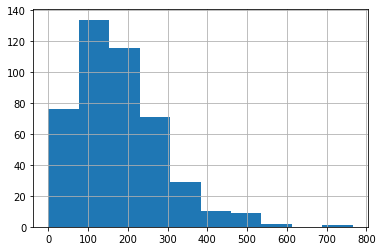

In [99]:
data['monthly_total_rainfall'].hist()

In [100]:
# Bin values into discrete intervals

data['rainfall_cat'] = pd.cut(data['monthly_total_rainfall'], bins=[0, 100, 200, 300, np.inf], 
                             labels=[1, 2, 3, 4])

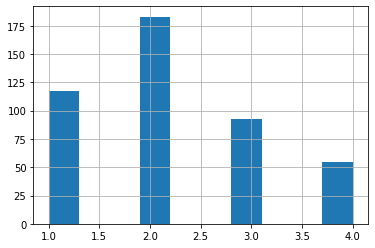

In [101]:
data['rainfall_cat'].hist()

In [102]:
# Perform stratified random splitting

strat_train_set, strat_test_set = train_test_split(data, test_size=0.2, random_state=1, stratify=data['rainfall_cat'])

In [103]:
# Perform pure random splitting

train_set, test_set = train_test_split(data, test_size=0.2, random_state=1)

Let's compare the proportions of rainfall_cat in stratified training set, random training set and the original training set.

In [104]:
def rainfall_cat_proportions(data):
    """Calculate the proportions of different monthly_total_rainfall_categories in the data
    
    Parameters
    ----------
    data: DataFrame object
        The dataset that contains rainfall_cat
    
    Return
    The proportions of rainfall_cat in data
    
    """
    return data["rainfall_cat"].value_counts() / len(data)

compare_proportions = pd.DataFrame({
    'Overall': rainfall_cat_proportions(data),
    'Stratified': rainfall_cat_proportions(strat_train_set),
    'Random': rainfall_cat_proportions(train_set)
})

compare_proportions

,Overall,Stratified,Random
2,0.408482,0.407821,0.382682
1,0.261161,0.262570,0.276536
3,0.207589,0.206704,0.223464
4,0.122768,0.122905,0.117318


- As seen above, stratified sampling gives **a more accurate representation** of the original dataset. It ensures that the splitted dataset gives a better coverage of the data population.
- Here is a famous incident of sampling bias: https://www.qualtrics.com/blog/the-1936-election-a-polling-catastrophe/ 

In [105]:
# Drop rainfall_cat

for sub_set in (strat_train_set, strat_test_set):
    sub_set.drop('rainfall_cat', axis=1, inplace=True)

In [106]:
# Create a copy for data visualization and exploration

train_copy = strat_train_set.copy()

# Data Visualization

## Correlation

In [107]:
# Check for correlation among numerical attributes

num_attribs = list(train_copy.columns)[1:]
corr_matrix = train_copy[num_attribs].corr()
corr_matrix['monthly_total_rainfall'].sort_values(ascending=False)

monthly_total_rainfall       1.000000
maximum_rainfall_in_a_day    0.795914
no_of_rainy_days             0.734224
mean_rh                      0.631349
rh_extremes_minimum          0.374669
temp_extremes_min           -0.292458
max_temperature             -0.358569
temp_mean_daily_min         -0.451990
mean_temp                   -0.492304
temp_mean_daily_max         -0.550890
mean_sunshine_hrs           -0.596920
Name: monthly_total_rainfall, dtype: float64

- As expected, the monthly_total_rainfall is highly (and positively) correlated to maximum_rainfall_in_a_day and no_of_rainy_days
- Also, there is a strong negative correlation between monthly_total_rainfall and mean_sunshine_hrs

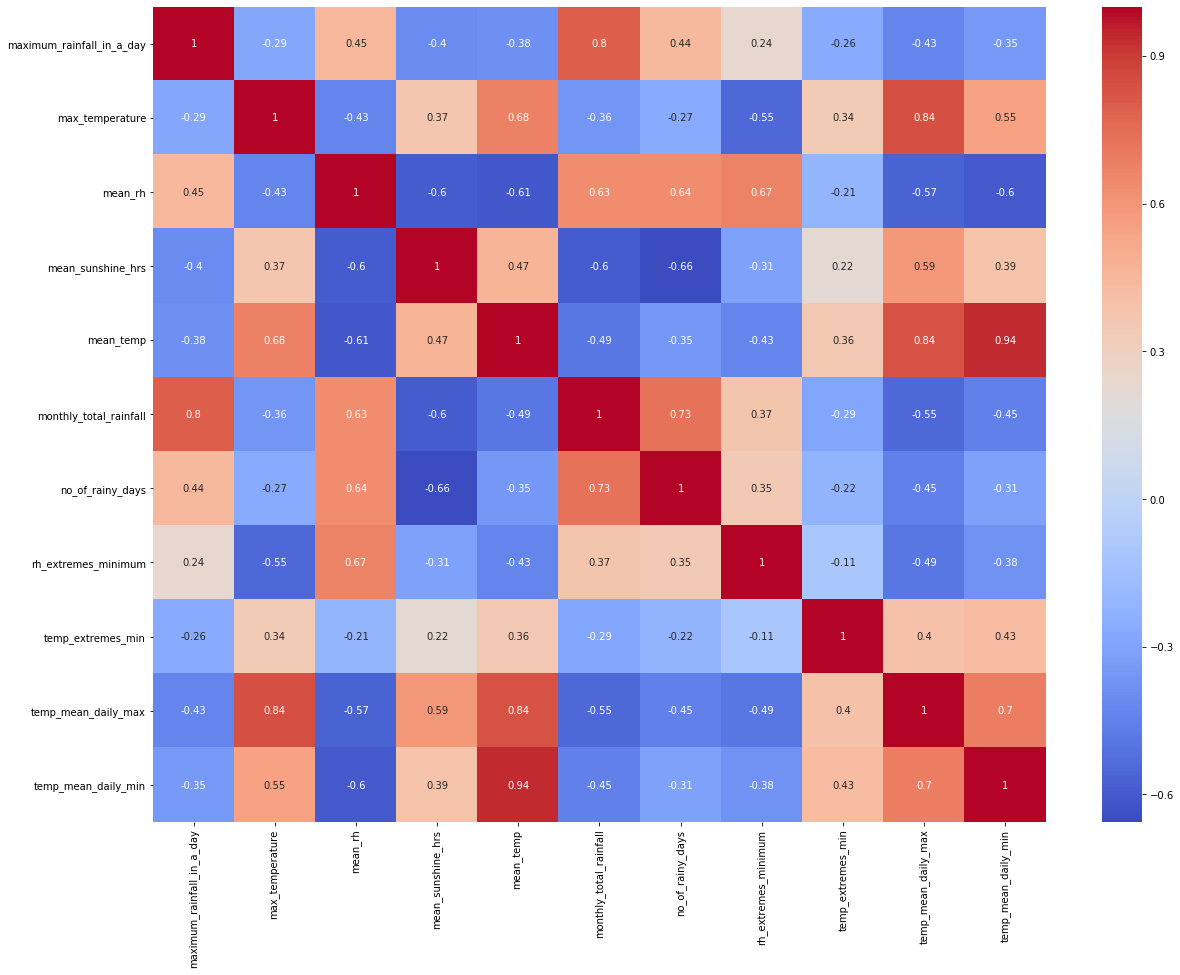

In [108]:
# Plot heat map

plt.figure(figsize=(20,15))
heat_map = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

- The features related to temperatures are positively correlated with each other. For example, temp_mean_daily_min has a positive correlation of 0.94 with mean_temp
- The features related to relative humidity exibit positive correlation with monthly_total_rainfall and no_of_rainy_days 
- Generally, the features in this dataset have a strong correlation with the target label

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000239AD230B38>,
      dtype=object)

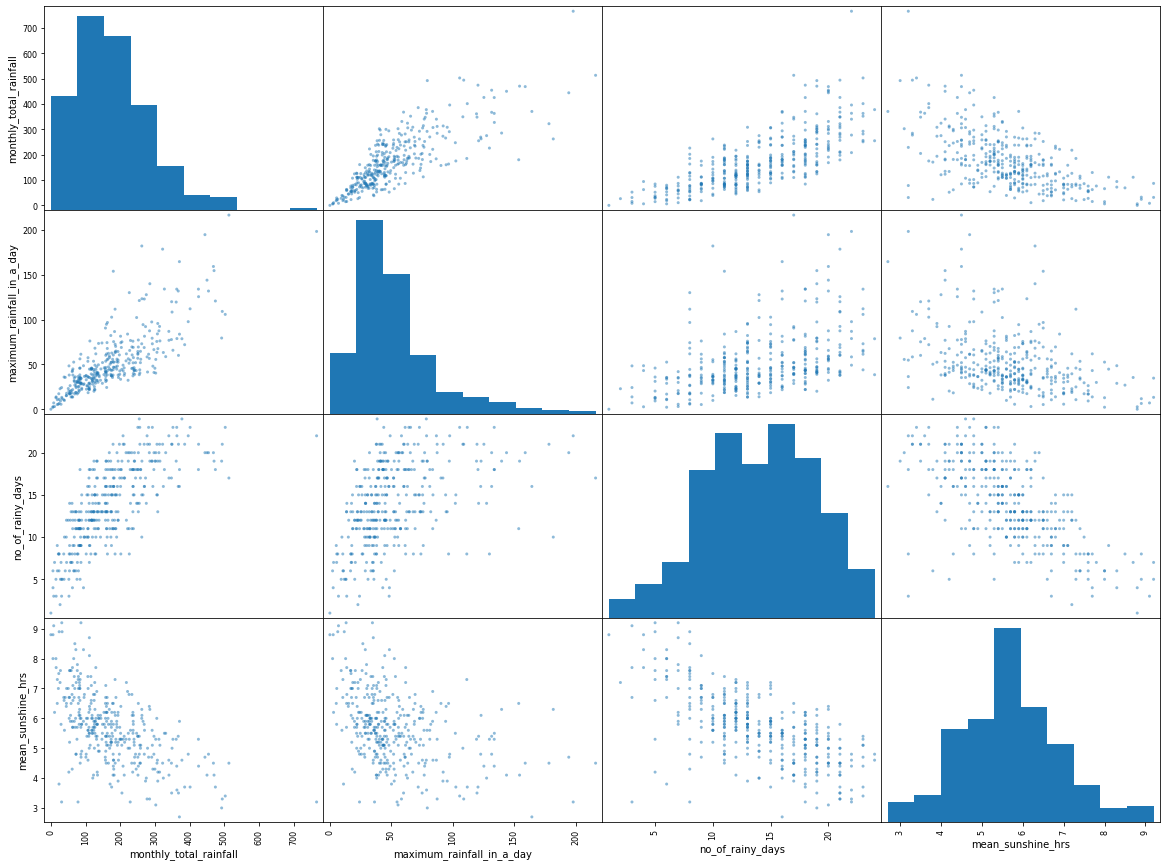

In [109]:
strong_attribs = ['monthly_total_rainfall', 'maximum_rainfall_in_a_day', 'no_of_rainy_days', 'mean_sunshine_hrs']
scatter_matrix(train_copy[strong_attribs], figsize=(20, 15))

## Check for skewness

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000239AD41EB38>,
      dtype=object)

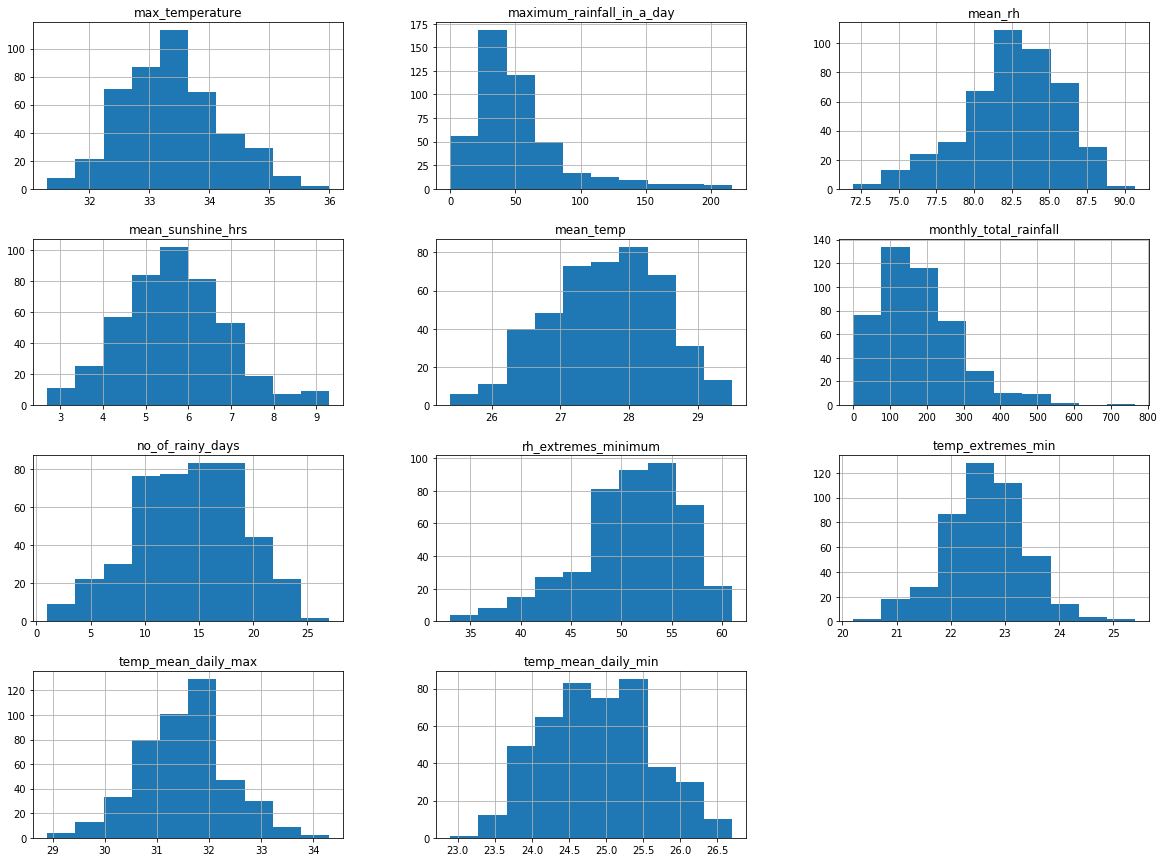

In [110]:
data.hist(figsize=(20, 15))

The scatter matrix shows that some features have slightly skewed distribution.

In [111]:
# Check skewness 

skews = [train_copy[attrib].skew() for attrib in num_attribs]
zipped = zip(num_attribs, skews)

# The code below will sort zipped based on skew in descending order
for attrib, skew in sorted(zipped, key=lambda t:t[1], reverse=True):
    print("%-30s : %f" %(attrib, skew))

maximum_rainfall_in_a_day      : 1.738316
monthly_total_rainfall         : 1.178499
mean_sunshine_hrs              : 0.335453
temp_mean_daily_min            : 0.150799
max_temperature                : 0.135070
temp_extremes_min              : 0.095358
temp_mean_daily_max            : -0.107618
no_of_rainy_days               : -0.152077
mean_temp                      : -0.220826
mean_rh                        : -0.529191
rh_extremes_minimum            : -0.652550


Maximum_rainfall_in_a_day is most skewed. Let's use the log function to transform the data and minimize skewness.

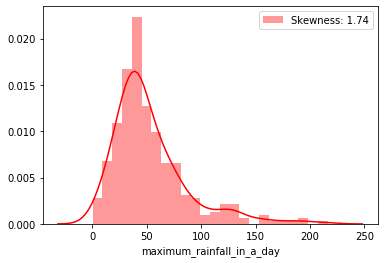

In [112]:
skew = train_copy['maximum_rainfall_in_a_day'].skew()
distplot = sns.distplot(train_copy['maximum_rainfall_in_a_day'], color='r', label=("Skewness: %.2f"%(skew)))
plt.legend()

In [113]:
def log_1(df, attrib='maximum_rainfall_in_a_day'):
    """Apply log + 1 transformation to attrib of X
    
    Parameters
    ----------
    df: DataFrame object
        Dataset
    attrib: String
        Attribute to be transformed
    
    Return
    ------
    Dataset with the transformed attribute (without the original attribute)
    """
    max_rainfall_in_a_day = df[attrib]
    
    # +1 to prevent log(0) 
    df["Log_" + attrib] = np.log(max_rainfall_in_a_day + 1)
    
    
    # Drop the original attribute 
    df.drop(attrib, axis=1, inplace=True)
    
    return df

In [114]:
log_1(train_copy).head()

,month,max_temperature,mean_rh,mean_sunshine_hrs,mean_temp,monthly_total_rainfall,no_of_rainy_days,rh_extremes_minimum,temp_extremes_min,temp_mean_daily_max,temp_mean_daily_min,Log_maximum_rainfall_in_a_day
240,2002-03,34.8,80.8,7.6,28.2,55.6,8.0,40.0,23.5,33.0,25.1,3.310543
225,2000-12,32.6,87.6,4.2,27.0,236.0,18.0,60.0,23.0,31.0,24.4,3.845883
72,1988-03,34.7,85.3,5.2,27.3,186.8,15.0,45.0,22.5,31.3,24.8,4.264087
68,1987-11,33.3,84.0,4.5,27.3,347.6,17.0,54.0,22.9,31.7,24.3,4.365643
53,1986-07,33.2,79.9,6.2,27.9,109.7,12.0,48.0,21.9,31.5,25.0,3.198673


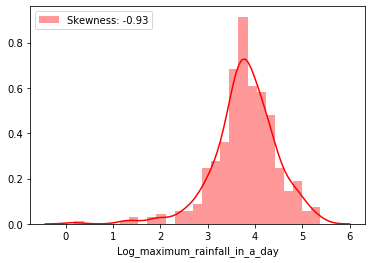

In [115]:
skew = train_copy['Log_maximum_rainfall_in_a_day'].skew()
distplot = sns.distplot(train_copy['Log_maximum_rainfall_in_a_day'], color='r', label=("Skewness: %.2f"%(skew)))
plt.legend()

The feature is now less skewed!

# Handle categorical attributes

- The 'month' column in the dataset should have a great effect on the total amount of rain per month in Singapore. 
- We can extract the year and month from this column.

In [116]:
cat_attrib = train_copy['month']
cat_attrib.head()

240    2002-03
225    2000-12
72     1988-03
68     1987-11
53     1986-07
Name: month, dtype: object

- The 'month' column is in the standard format of YYYY-MM. Hence, it is easy to process this column with a function to extract the year and month.
- Year will be treated as an **ordinal feature** as it is ordered. Eg: 2018 > 1997 > 1983. 
- Technically, month is ordered as well (Dec > May > Jan). However, since month goes in rounds (Jan comes after Dec), it will be treated as a **nominal feature**.

In [117]:
def process_year_month(df, cat_attrib = 'month'):
    """Splits the 'month' column into 'year' and 'month'
    
    Parameters:
    ----------
    df: DataFrame object
        Dataset that contains the 'month' column
    
    cat_attrib: string object
        A default of the month column
    
    Return:
    -------
    A new df with 'year' column (as integers) and 'month' column (as strings)
    
    """
    cat_attrib = df[cat_attrib]

    years, months = [], []

    for s in cat_attrib:
        year, month = s.split('-')
        years.append(int(year))
        months.append(month)
    
    new_df = df.copy()
    
    new_df['year'], new_df['month'] = [years, months]
    
    return new_df

In [118]:
train_copy = process_year_month(train_copy)
train_copy.head()

,month,max_temperature,mean_rh,mean_sunshine_hrs,mean_temp,monthly_total_rainfall,no_of_rainy_days,rh_extremes_minimum,temp_extremes_min,temp_mean_daily_max,temp_mean_daily_min,Log_maximum_rainfall_in_a_day,year
240,03,34.8,80.8,7.6,28.2,55.6,8.0,40.0,23.5,33.0,25.1,3.310543,2002
225,12,32.6,87.6,4.2,27.0,236.0,18.0,60.0,23.0,31.0,24.4,3.845883,2000
72,03,34.7,85.3,5.2,27.3,186.8,15.0,45.0,22.5,31.3,24.8,4.264087,1988
68,11,33.3,84.0,4.5,27.3,347.6,17.0,54.0,22.9,31.7,24.3,4.365643,1987
53,07,33.2,79.9,6.2,27.9,109.7,12.0,48.0,21.9,31.5,25.0,3.198673,1986


Before we proceed, let's analyze the relationship between month, year and monthly_total_rainfall.

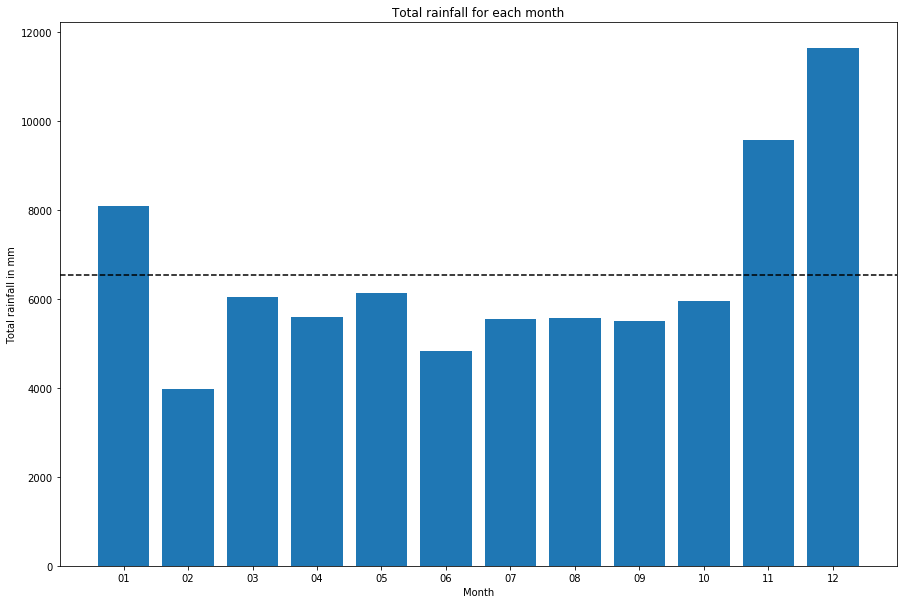

In [119]:
# Use the complete dataset to prevent missing data and hence inaccurate visualization
new_data = process_year_month(data)

months = np.unique(new_data['month'])

plt.figure(figsize=(15, 10))

# Ignore 2019 as data is recorded until June only
rain_sums = [new_data[(new_data['month'] == month) & 
                        (new_data['year'] != 2019)].sum()['monthly_total_rainfall'] for month in months]

plt.bar(months, rain_sums)
plt.xlabel('Month')
plt.ylabel('Total rainfall in mm')
plt.title('Total rainfall for each month')
plt.axhline(y=np.mean(rain_sums), linestyle='--', color='k')

Based on the bar chart above, February is Singapore's dryest month.

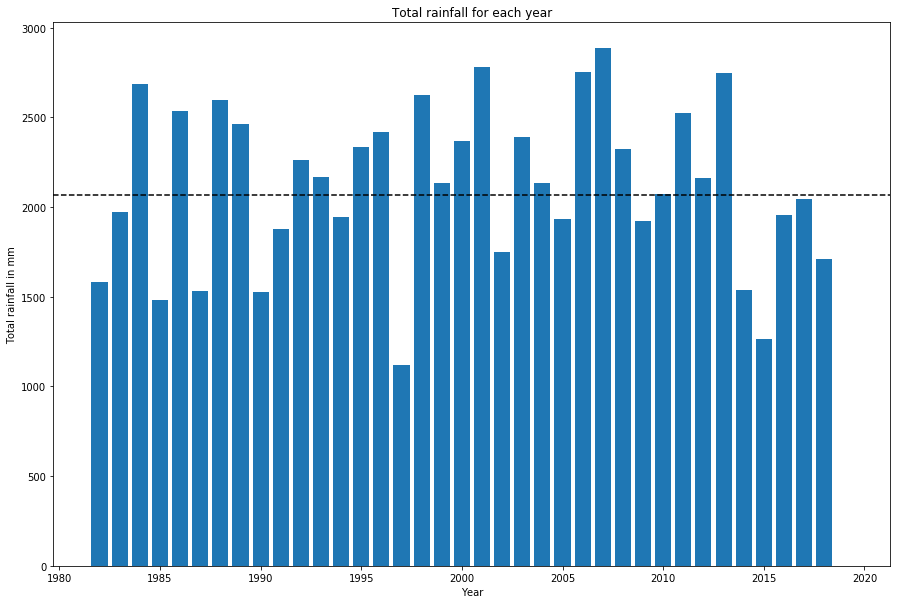

In [120]:
years = np.unique(new_data['year'])

plt.figure(figsize=(15, 10))

# Ignore 2019 as data is recorded until June only
rain_sums = [new_data[(new_data['year'] == year) &
                       (new_data['year'] != 2019)].sum()['monthly_total_rainfall'] for year in years]

plt.bar(years, rain_sums)
plt.xlabel('Year')
plt.ylabel('Total rainfall in mm')
plt.title('Total rainfall for each year')
plt.axhline(y=np.mean(rain_sums), linestyle='--', color='k')

Singapore seems to experience an extreme drought in year 1997.

Then, the new 'month' column will be encoded into one-hot vectors. Pandas' get_dummies method will be used.

In [121]:
def one_hot_encoder(df, column='month'):
    """Perform one-hot encoding on the new 'month' column
    
    Parameters:
    ----------
    df: DataFrame object
        Dataset that contains the new 'month' column
    
    column: string object
        Name of column to be one-hot encoded
    
    Return:
    -------
    A new df with 12 one-hot columns with each corresponds to a month
    
    """
    # Drop m_01 to reduce multicollinearity 
    encoded_df = pd.get_dummies(df, columns=[column], prefix='m', drop_first=True)
    
    return encoded_df

In [122]:
train_copy = one_hot_encoder(train_copy)
train_copy.head()

,max_temperature,mean_rh,mean_sunshine_hrs,mean_temp,monthly_total_rainfall,no_of_rainy_days,rh_extremes_minimum,temp_extremes_min,temp_mean_daily_max,temp_mean_daily_min,...,m_03,m_04,m_05,m_06,m_07,m_08,m_09,m_10,m_11,m_12
240,34.8,80.8,7.6,28.2,55.6,8.0,40.0,23.5,33.0,25.1,...,1,0,0,0,0,0,0,0,0,0
225,32.6,87.6,4.2,27.0,236.0,18.0,60.0,23.0,31.0,24.4,...,0,0,0,0,0,0,0,0,0,1
72,34.7,85.3,5.2,27.3,186.8,15.0,45.0,22.5,31.3,24.8,...,1,0,0,0,0,0,0,0,0,0
68,33.3,84.0,4.5,27.3,347.6,17.0,54.0,22.9,31.7,24.3,...,0,0,0,0,0,0,0,0,1,0
53,33.2,79.9,6.2,27.9,109.7,12.0,48.0,21.9,31.5,25.0,...,0,0,0,0,1,0,0,0,0,0


# Data Transformation Pipeline

In [123]:
X_train = strat_train_set.drop(['monthly_total_rainfall'], axis=1)
y_train = strat_train_set['monthly_total_rainfall'].copy()

In [124]:
data_pipeline = Pipeline([
    ('log', FunctionTransformer(log_1, validate=False)),
    ('year_month', FunctionTransformer(process_year_month, validate=False)),
    ('one_hot', FunctionTransformer(one_hot_encoder, validate=False)),
    ('std_scaler', StandardScaler())
])

X_train_tr = data_pipeline.fit_transform(X_train)

In [125]:
X_train_tr

array([[ 1.7228999 , -0.52167907,  1.62220131, ..., -0.30789807,
        -0.30242919, -0.30789807],
       [-0.94669672,  1.53496147, -1.22091379, ..., -0.30789807,
        -0.30242919,  3.24782806],
       [ 1.6015546 ,  0.83933305, -0.38470346, ..., -0.30789807,
        -0.30242919, -0.30789807],
       ...,
       [-0.58266081, -0.15874251, -0.97005069, ...,  3.24782806,
        -0.30242919, -0.30789807],
       [ 0.14541099,  0.32517292,  1.03685409, ..., -0.30789807,
        -0.30242919, -0.30789807],
       [ 1.35886399,  1.17202491,  0.0334017 , ..., -0.30789807,
        -0.30242919, -0.30789807]])

# Machine Learning Models

The following models will be evaluated:

1. Linear Regressor
2. Ridge Regressor
3. Decision Tree Regressor
4. Linear Support Vector Machine
5. Bagging Regressor
6. AdaBoost Regressor
7. GradientBoosting Regressor
8. Random Forest Regressor
9. Extra Trees Regressor
10. Polynomial Regressor

In [126]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [127]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_tr)

In [128]:
lin_reg = LinearRegression()
ridge_reg = Ridge(random_state=1)
tree_reg = DecisionTreeRegressor(random_state=1)
lin_svr = LinearSVR(random_state=1)
svr = SVR(gamma='scale')
bag_reg = BaggingRegressor(random_state=1)
ada_boost = AdaBoostRegressor(random_state=1)
grad_boost = GradientBoostingRegressor(random_state=1)
forest_reg = RandomForestRegressor(random_state=1, n_estimators=10)
extra_tree = ExtraTreesRegressor(random_state=1, n_estimators=10)

reg_models = [lin_reg, ridge_reg, tree_reg, lin_svr, bag_reg, ada_boost, grad_boost,
             forest_reg, extra_tree, svr]
model_names = ['Linear Regression', 'Ridge Regression', 'Decision Tree Regressor', 'Linear SVR',
              'Bagging Regressor', 'Ada Boost Regressor', 'Gradient Boost Regressor', 'Random Forest Regressor',
              'Extra Trees Regressor', 'RBF SVR', 'Polynomial Regression']

In [129]:
cross_val_scores = [np.sqrt(-cross_val_score(model, X_train_tr, y_train, scoring='neg_mean_squared_error', cv=5)).mean() for model in reg_models]

cross_val_scores.append(np.sqrt(-cross_val_score(lin_reg, X_train_poly, y_train, scoring='neg_mean_squared_error', cv=5)).mean())

In [130]:
zipped = zip(model_names, cross_val_scores)

for model, score in sorted(zipped, key=lambda t:t[1], reverse=False):
    print("%-30s : %f" %(model, score))

Bagging Regressor              : 46.846918
Random Forest Regressor        : 47.114534
Gradient Boost Regressor       : 47.137082
Ada Boost Regressor            : 50.499217
Extra Trees Regressor          : 50.997869
Ridge Regression               : 53.437674
Linear Regression              : 53.530002
Decision Tree Regressor        : 64.555299
Linear SVR                     : 70.592805
Polynomial Regression          : 97.295046
RBF SVR                        : 101.872323


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

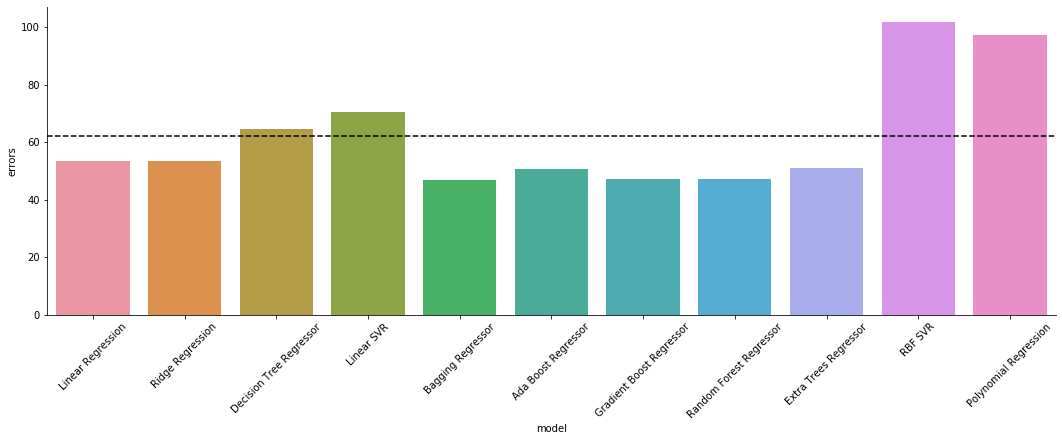

In [131]:
scores = pd.DataFrame({
    'errors': cross_val_scores,
    'model': model_names
})

plot = sns.catplot(x='model', y='errors', data=scores, kind='bar', aspect=3)
plt.axhline(y=np.mean(cross_val_scores), linestyle='--', color='k')
plt.xticks(fontsize=10, rotation=45)

- Support Vector Machines do not perform well with this dataset. 
- Linear Regression models outperform Polynomial Regression.
- Decision Tree doesn't perform well. This could be due to overfitting as it is not regulated.
- The remaining ensemble models perform well.

# Hyperparameter Tuning

- An ensemble model will be built with Scikit-Learn's VotingRegressor. 
- I have chosen Ridge Regressor, Random Forest Regressor and Ada Boost Regressor to be part of the ensemble as the models are high performing and diverse.

In [132]:
def tuning_result(model_name, search):
    """Print out the results of hyperparameter tuning
    
    Parameters:
    -----------
    model_name: Scikit-Learn's estimator
        A trained model for regression tasks
    search: 
        Scikit-Learn's GridSearchCV or RandomizedSearchCV that are fitted
        
    Return:
    -------
    The best parameters and score of the trained model 
    """
    print(model_name, "best params:", search.best_params_)
    print(model_name, "best cross val error:", np.sqrt(-search.best_score_))

## Ridge Regression

In [133]:
ridge_param_dist = {
    'alpha':randint(low=1, high=100),
    'solver': ['auto', 'svd', 'cholesky', 'saga']
}

ridge_rand_search = RandomizedSearchCV(ridge_reg, ridge_param_dist, cv=5, scoring='neg_mean_squared_error', random_state=1, iid=False)
ridge_rand_search.fit(X_train_tr, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=1, solver='auto', tol=0.001),
                   iid=False, n_iter=10, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000239AAE012E8>,
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'saga']},
                   pre_dispatch='2*n_jobs', random_state=1, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

In [134]:
tuning_result("Ridge Regression", ridge_rand_search)
best_ridge_reg = ridge_rand_search.best_estimator_

best_ridge_reg.fit(X_train_tr, y_train)
y_pred = best_ridge_reg.predict(X_train_tr)
print('Ridge Regression training error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('Ridge Regression R^2 score:', best_ridge_reg.score(X_train_tr, y_train))

Ridge Regression best params: {'alpha': 13, 'solver': 'auto'}
Ridge Regression best cross val error: 53.702144327400916
Ridge Regression training error: 50.652674107644835
Ridge Regression R^2 score: 0.7826275608554868


## Random Forest

In [135]:
forest_param_dist = {
    'max_depth': randint(low=1, high=5), 
    'n_estimators':randint(low=1, high=200),
    'max_features': randint(low=1, high=X_train_tr.shape[1])
}

forest_rand_search = RandomizedSearchCV(forest_reg, forest_param_dist, 
                                        n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=1, iid=False)
forest_rand_search.fit(X_train_tr, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=1...


In [136]:
tuning_result("Random Forest", forest_rand_search)
best_forest_reg = forest_rand_search.best_estimator_

best_forest_reg.fit(X_train_tr, y_train)
y_pred = best_forest_reg.predict(X_train_tr)
print('Random Forest training error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('Random Forest R^2 score:', best_forest_reg.score(X_train_tr, y_train))

Random Forest best params: {'max_depth': 3, 'max_features': 21, 'n_estimators': 102}
Random Forest best cross val error: 49.67993683624857
Random Forest training error: 41.053667059695975
Random Forest R^2 score: 0.8572080796010403


## AdaBoost Regressor

In [137]:
dec_tree = DecisionTreeRegressor(random_state=1)
ada_boost = AdaBoostRegressor(base_estimator=dec_tree)

ada_param_dist = {
    'base_estimator__max_depth': randint(low=1, high=5),
    'base_estimator__max_features': randint(low=1, high=X_train_tr.shape[1]),
    'n_estimators': randint(low=1, high=200),
    'learning_rate': uniform(loc=0, scale=1)
}

ada_rand_search = RandomizedSearchCV(ada_boost, ada_param_dist, 
                                        n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=1, iid=False)
ada_rand_search.fit(X_train_tr, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=None,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_

In [138]:
tuning_result("Ada Boost", ada_rand_search)
best_ada_boost = ada_rand_search.best_estimator_

best_ada_boost.fit(X_train_tr, y_train)
y_pred = best_ada_boost.predict(X_train_tr)
print('Ada Boost training error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('Ada Boost R^2 score:', best_ada_boost.score(X_train_tr, y_train))

Ada Boost best params: {'base_estimator__max_depth': 3, 'base_estimator__max_features': 21, 'learning_rate': 0.20445224973151743, 'n_estimators': 157}
Ada Boost best cross val error: 49.87952792787507
Ada Boost training error: 38.24901731889726
Ada Boost R^2 score: 0.8760517822698423


# Learning Curves

In [139]:
def plot_learning_curve(model, title, X=X_train_tr, y=y_train, cv=5, train_sizes = np.linspace(0.1, 1.0, 6)):
    
    #learning_curve returns scores instead of errors
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv)
    
    #Calculate mean and std of the scores
    train_score_mean = train_scores.mean(axis=1)
    test_score_mean = test_scores.mean(axis=1)
    train_score_std = train_scores.std(axis=1)
    test_score_std = test_scores.std(axis=1)
    
    #Plot the learning curve
    plt.plot(train_sizes, train_score_mean, label='Training score', color='r')
    plt.plot(train_sizes, test_score_mean, label='Test score', color='g')
    
    #Visualize the scores with their std
    plt.fill_between(train_sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color='r', alpha=0.1)
    plt.fill_between(train_sizes, test_score_mean - test_score_std, test_score_mean + test_score_std, color='g', alpha=0.1)
    
    #Figure labelling
    plt.xlabel('Training Set Size')
    plt.ylabel('Scores')
    plt.title(title)
    plt.legend(loc='lower right')

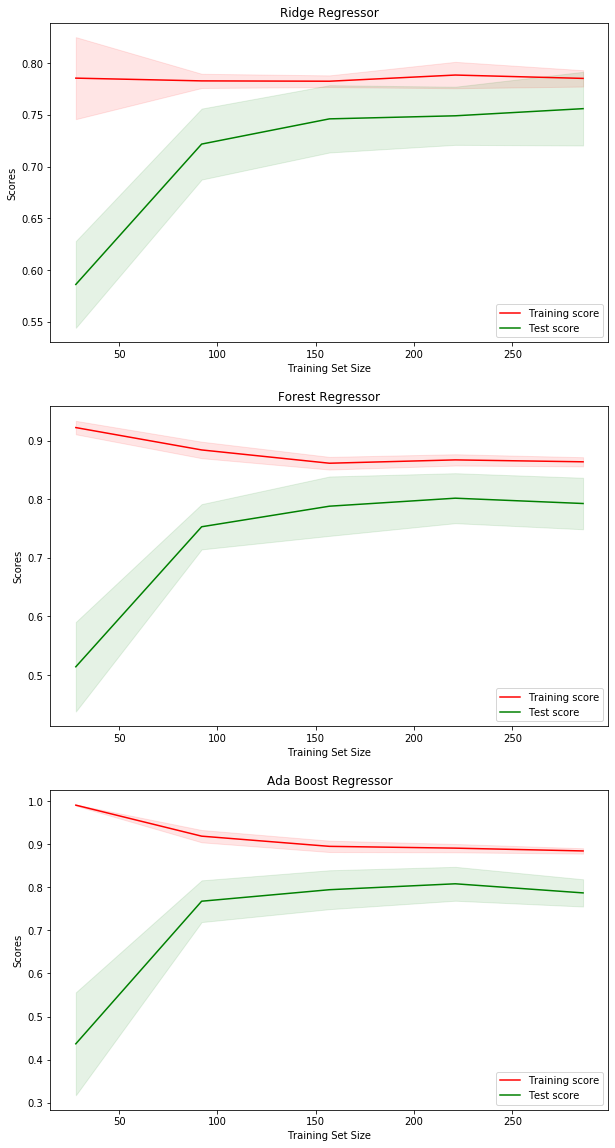

In [140]:
best_models = [best_ridge_reg, best_forest_reg, best_ada_boost]
titles = ["Ridge Regressor", "Forest Regressor", "Ada Boost Regressor"]

plt.figure(figsize=(10, 20))
plt.subplot(311)

for i, zipped in enumerate(zip(titles, best_models)):
    plt.subplot(311 + i)
    title, best_model = zipped[0], zipped[1]
    plot_learning_curve(best_model, title)

- The models tend to overfit the training data.
- However, we shouldn't continue tweaking the hyperparameters again to reduce overfitting. If we do so, we will "overfit" the hyperparameters, which will result in bad generalization for unseen / test data.

# Ensemble Model

In [141]:
ensemble_reg = VotingRegressor(
    estimators=[('Ridge Reg', best_ridge_reg), ('Random Forest', best_forest_reg), ('Ada Boost', best_ada_boost)]                                                       
)

ensemble_reg.fit(X_train_tr, y_train)
y_pred = ensemble_reg.predict(X_train_tr)

errors = cross_val_score(ensemble_reg, X_train_tr, y_train, scoring='neg_mean_squared_error', cv=5)
print("Cross validation error:", np.sqrt(-errors).mean())
print("Training error:", np.sqrt(mean_squared_error(y_train, y_pred)))
print('R^2 score:', ensemble_reg.score(X_train_tr, y_train))

Cross validation error: 46.79174195347739
Training error: 39.34552713745427
R^2 score: 0.8688433066279868


An ensemble of the three models above has produced much better results. Although the R<sup>2</sup> score of the ensemble is lower than that of Ada Boost Regressor, this could mean that the ensemble doesn't overfit the data as much as Ada Boost.

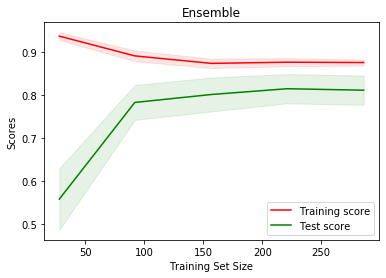

In [142]:
plot_learning_curve(ensemble_reg, "Ensemble")

# Feature Importances with Forest-Based Estimator

In [143]:
tr_features = ['max_temperature', 'mean_rh', 'mean_sunshine_hrs', 'mean_temp', 'no_of_rainy_days','rh_extremes_minimum',
 'temp_extremes_min', 'temp_mean_daily_max', 'temp_mean_daily_min', 'Log_maximum_rainfall_in_a_day', 'year',
 'm_02', 'm_03', 'm_04', 'm_05', 'm_06', 'm_07', 'm_08', 'm_09', 'm_10', 'm_11', 'm_12']

importances = best_forest_reg.feature_importances_
indices = np.argsort(importances)[::-1] # To get descending order

for f in range(X_train_tr.shape[1]):
    print("%d) %-30s %f" %(f+1, tr_features[indices[f]], importances[indices[f]]))

1) Log_maximum_rainfall_in_a_day  0.644799
2) no_of_rainy_days               0.236873
3) temp_mean_daily_max            0.042390
4) mean_rh                        0.041564
5) mean_sunshine_hrs              0.014456
6) mean_temp                      0.009819
7) temp_mean_daily_min            0.003191
8) max_temperature                0.002645
9) m_12                           0.001709
10) rh_extremes_minimum            0.001611
11) temp_extremes_min              0.000867
12) year                           0.000075
13) m_03                           0.000000
14) m_02                           0.000000
15) m_11                           0.000000
16) m_04                           0.000000
17) m_05                           0.000000
18) m_06                           0.000000
19) m_07                           0.000000
20) m_08                           0.000000
21) m_09                           0.000000
22) m_10                           0.000000


Text(0.5, 1.0, 'Feature Importances')

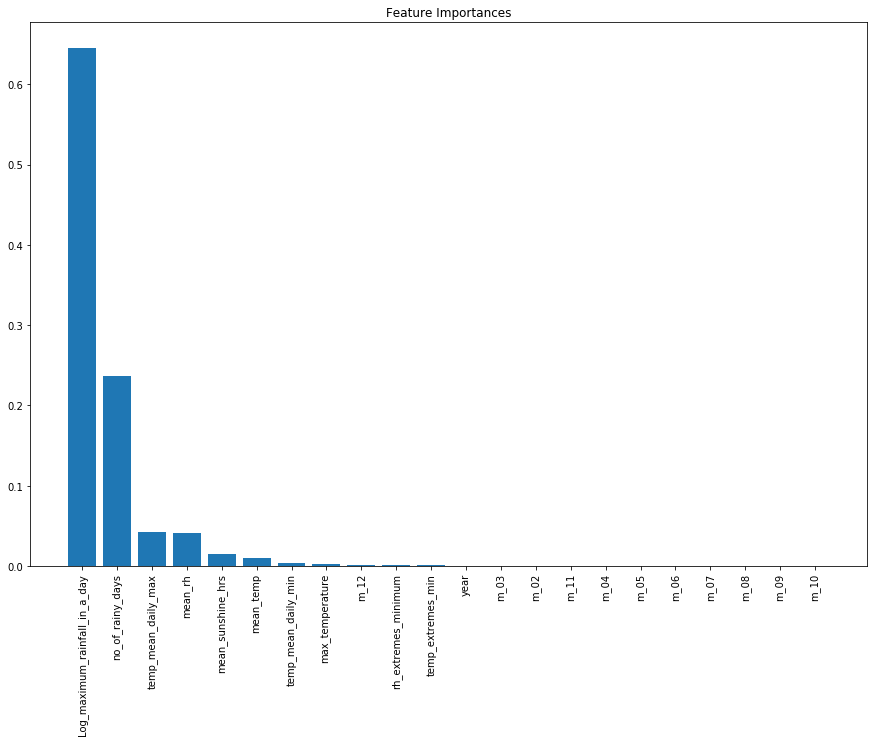

In [144]:
plt.figure(figsize=(15, 10))

plt.bar(range(X_train_tr.shape[1]), importances[indices])
plt.xticks(range(X_train_tr.shape[1]), np.array(tr_features)[indices], rotation=90)
plt.title('Feature Importances')

- It turns out that year and month didn't provide useful information for the model.
- We can transform the dataset with Scikit-Learn's SelectFromModel.

In [145]:
# Select features with feature score > median
# The 'mean' threshold is not used as the feature scores are extremely skewed.  
sfm = SelectFromModel(best_forest_reg, threshold='median') 
sfm.fit(X_train_tr, y_train)
X_train_selected = sfm.transform(X_train_tr) # Dataset with reduced features

for f in range(X_train_selected.shape[1]):
    print("%d) %-30s %f" %(f+1, tr_features[indices[f]], importances[indices[f]]))

1) Log_maximum_rainfall_in_a_day  0.644799
2) no_of_rainy_days               0.236873
3) temp_mean_daily_max            0.042390
4) mean_rh                        0.041564
5) mean_sunshine_hrs              0.014456
6) mean_temp                      0.009819
7) temp_mean_daily_min            0.003191
8) max_temperature                0.002645
9) m_12                           0.001709
10) rh_extremes_minimum            0.001611
11) temp_extremes_min              0.000867


You can then retrain the model with this new dataset to evaluate its performance again.

# Final Evaluation on Test Set

In [146]:
X_test = strat_test_set.drop(['monthly_total_rainfall'], axis=1)
y_test = strat_test_set['monthly_total_rainfall'].copy()

In [147]:
X_test_tr = data_pipeline.transform(X_test)

In [148]:
y_pred = ensemble_reg.predict(X_test_tr)
print("Test error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score:", ensemble_reg.score(X_test_tr, y_test))

Test error: 60.2975011375506
R2 score: 0.7548310826325862


The end!😎